In [1]:
!pip install nb-black


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import sys

sys.path.insert(0, "../")

## Dataset

In [4]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [11]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [12]:
signal.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [13]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [14]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [15]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

(torch.Size([2592, 1001, 22]), torch.Size([22]))

In [16]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

torch.Size([2592, 22, 1001])

In [18]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

KeyboardInterrupt: 

In [ ]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

In [ ]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

In [ ]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

In [ ]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [19]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [20]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[6],
)

In [21]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [22]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[6],
)

In [23]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [25]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [26]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [27]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

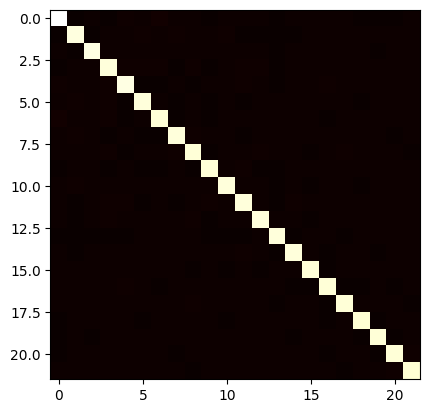

In [28]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [29]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [30]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [31]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [32]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [33]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:01,  4.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.410045067469279


Train -  [0.25, 0.0, 0.6545138888888888, 0.25, tensor(1.3957)]
Validation -  [0.25, 0.0, 0.5653131430041153, 0.25, tensor(1.3974)]

Epoch  1


9it [00:00, 10.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4026345014572144


Train -  [0.25, 0.0, 0.7029963991769548, 0.25, tensor(1.3953)]
Validation -  [0.25, 0.0, 0.5963702417695473, 0.25, tensor(1.3980)]

Epoch  2


9it [00:01,  7.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3997159136666193


Train -  [0.3333333333333333, 0.11111111111111116, 0.7193769290123457, 0.3333333333333333, tensor(1.3897)]
Validation -  [0.2777777777777778, 0.03703703703703709, 0.6094714506172839, 0.2777777777777778, tensor(1.3923)]

Epoch  3


9it [00:01,  7.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3961848550372653


Train -  [0.2986111111111111, 0.06481481481481477, 0.7304848251028807, 0.2986111111111111, tensor(1.3865)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.6189396862139918, 0.2847222222222222, tensor(1.3900)]

Epoch  4


9it [00:00,  9.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3931303421656291


Train -  [0.3541666666666667, 0.13888888888888884, 0.742332175925926, 0.3541666666666667, tensor(1.3814)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.6244212962962963, 0.3090277777777778, tensor(1.3859)]

Epoch  5


9it [00:01,  7.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3937437136967976


Train -  [0.25, 0.0, 0.7628118569958848, 0.25, tensor(1.3785)]
Validation -  [0.25, 0.0, 0.6403034979423868, 0.25, tensor(1.3831)]

Epoch  6


9it [00:01,  8.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3897584544287787


Train -  [0.25, 0.0, 0.7708494084362141, 0.25, tensor(1.3851)]
Validation -  [0.25, 0.0, 0.6551729681069958, 0.25, tensor(1.3928)]

Epoch  7


9it [00:01,  6.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3798806269963582


Train -  [0.3194444444444444, 0.09259259259259256, 0.7779385288065843, 0.3194444444444444, tensor(1.3709)]
Validation -  [0.2777777777777778, 0.03703703703703709, 0.6576163837448559, 0.2777777777777778, tensor(1.3787)]

Epoch  8


9it [00:01,  8.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3729170428382025


Train -  [0.46875, 0.29166666666666663, 0.7784047067901235, 0.46875, tensor(1.3638)]
Validation -  [0.3645833333333333, 0.1527777777777778, 0.6597061471193416, 0.36458333333333326, tensor(1.3746)]

Epoch  9


9it [00:01,  6.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3629436890284221


Train -  [0.2569444444444444, 0.0092592592592593, 0.7681809413580247, 0.2569444444444444, tensor(1.3599)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.6552533436213992, 0.2569444444444444, tensor(1.3720)]

Epoch  10


9it [00:00,  9.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3670838276545207


Train -  [0.3715277777777778, 0.1620370370370371, 0.7781153549382717, 0.3715277777777778, tensor(1.3528)]
Validation -  [0.3020833333333333, 0.06944444444444442, 0.6640303497942388, 0.3020833333333333, tensor(1.3694)]

Epoch  11


9it [00:01,  7.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3829026222229004


Train -  [0.2604166666666667, 0.01388888888888884, 0.7594200102880657, 0.2604166666666667, tensor(1.3672)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.6491769547325102, 0.2986111111111111, tensor(1.3794)]

Epoch  12


9it [00:01,  8.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3946561680899725


Train -  [0.3715277777777778, 0.1620370370370371, 0.7433288323045268, 0.3715277777777778, tensor(1.3851)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6422968106995885, 0.3333333333333333, tensor(1.3997)]

Epoch  13


9it [00:01,  7.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4164042207929823


Train -  [0.3402777777777778, 0.12037037037037035, 0.7255336934156379, 0.3402777777777778, tensor(1.3861)]
Validation -  [0.3020833333333333, 0.06944444444444442, 0.6427790637860082, 0.3020833333333333, tensor(1.3997)]

Epoch  14


9it [00:01,  7.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4039338032404582


Train -  [0.25, 0.0, 0.7529417438271605, 0.25, tensor(1.4198)]
Validation -  [0.25, 0.0, 0.63403420781893, 0.25, tensor(1.4353)]

Epoch  15


9it [00:01,  7.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4021201531092327


Train -  [0.25, 0.0, 0.7028838734567902, 0.25, tensor(1.4058)]
Validation -  [0.25, 0.0, 0.6403356481481481, 0.25, tensor(1.4116)]

Epoch  16


9it [00:01,  8.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3744179275300767


Train -  [0.25, 0.0, 0.7614454732510288, 0.25, tensor(1.4162)]
Validation -  [0.25, 0.0, 0.6788676697530865, 0.25, tensor(1.4324)]

Epoch  17


9it [00:01,  7.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4174475140041776


Train -  [0.3576388888888889, 0.1435185185185185, 0.7534400720164609, 0.3576388888888889, tensor(1.3461)]
Validation -  [0.2951388888888889, 0.06018518518518523, 0.6725180041152263, 0.2951388888888889, tensor(1.3697)]

Epoch  18


9it [00:01,  7.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3476369910769992


Train -  [0.4305555555555556, 0.2407407407407407, 0.7503375771604939, 0.4305555555555556, tensor(1.3309)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.665943287037037, 0.4097222222222222, tensor(1.3545)]

Epoch  19


9it [00:01,  8.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.331986837916904


Train -  [0.4756944444444444, 0.30092592592592593, 0.7596450617283951, 0.4756944444444444, tensor(1.3188)]
Validation -  [0.3368055555555556, 0.1157407407407407, 0.6655092592592593, 0.3368055555555556, tensor(1.3527)]

Epoch  20


9it [00:01,  6.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3329929775661893


Train -  [0.3923611111111111, 0.18981481481481477, 0.7606738683127573, 0.3923611111111111, tensor(1.3188)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.6514435442386831, 0.3229166666666667, tensor(1.3536)]

Epoch  21


9it [00:01,  6.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3375204139285617


Train -  [0.4548611111111111, 0.27314814814814814, 0.753954475308642, 0.4548611111111111, tensor(1.3114)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6623906893004116, 0.36805555555555564, tensor(1.3429)]

Epoch  22


9it [00:01,  5.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3070135513941448


Train -  [0.375, 0.16666666666666663, 0.7573784722222223, 0.375, tensor(1.3213)]
Validation -  [0.34375, 0.125, 0.6484696502057613, 0.34375, tensor(1.3552)]

Epoch  23


9it [00:01,  5.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3217400974697537


Train -  [0.375, 0.16666666666666663, 0.7595646862139918, 0.375, tensor(1.3187)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.6561213991769548, 0.3402777777777778, tensor(1.3533)]

Epoch  24


9it [00:01,  6.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.310386406050788


Train -  [0.4548611111111111, 0.27314814814814814, 0.7735982510288066, 0.4548611111111111, tensor(1.2869)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.6588702417695472, 0.3402777777777778, tensor(1.3471)]

Epoch  25


9it [00:01,  6.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2995767858293321


Train -  [0.4722222222222222, 0.2962962962962963, 0.7798353909465021, 0.4722222222222222, tensor(1.2754)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.6599311985596708, 0.3784722222222222, tensor(1.3352)]

Epoch  26


9it [00:01,  6.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.275296343697442


Train -  [0.5486111111111112, 0.39814814814814814, 0.7835165895061729, 0.5486111111111112, tensor(1.2635)]
Validation -  [0.40625, 0.20833333333333337, 0.6693994341563786, 0.40625, tensor(1.3273)]

Epoch  27


9it [00:01,  5.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2702196439107258


Train -  [0.4131944444444444, 0.21759259259259256, 0.7861207561728396, 0.4131944444444444, tensor(1.2717)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.6681134259259259, 0.3611111111111111, tensor(1.3260)]

Epoch  28


9it [00:01,  6.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2595148351457384


Train -  [0.4548611111111111, 0.27314814814814814, 0.79296875, 0.4548611111111111, tensor(1.2671)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.6644322273662552, 0.3506944444444444, tensor(1.3342)]

Epoch  29


9it [00:01,  7.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.279289682706197


Train -  [0.4270833333333333, 0.23611111111111116, 0.7798032407407407, 0.4270833333333333, tensor(1.2861)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6774530606995885, 0.36805555555555564, tensor(1.3359)]

Epoch  30


9it [00:01,  7.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.256410837173462


Train -  [0.4201388888888889, 0.22685185185185186, 0.7931134259259258, 0.4201388888888889, tensor(1.2715)]
Validation -  [0.3298611111111111, 0.10648148148148151, 0.6633230452674898, 0.3298611111111111, tensor(1.3356)]

Epoch  31


9it [00:01,  5.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2740878793928359


Train -  [0.4895833333333333, 0.3194444444444444, 0.8052662037037037, 0.4895833333333333, tensor(1.2804)]
Validation -  [0.375, 0.16666666666666663, 0.6677276234567902, 0.375, tensor(1.3516)]

Epoch  32


9it [00:01,  7.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2708492808871799


Train -  [0.4756944444444444, 0.30092592592592593, 0.8045428240740742, 0.4756944444444444, tensor(1.2597)]
Validation -  [0.3368055555555556, 0.1157407407407407, 0.6722608024691357, 0.3368055555555556, tensor(1.3512)]

Epoch  33


9it [00:01,  6.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2458511193593342


Train -  [0.4791666666666667, 0.3055555555555556, 0.8232542438271605, 0.4791666666666667, tensor(1.2379)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.6800572273662551, 0.3229166666666667, tensor(1.3373)]

Epoch  34


9it [00:01,  5.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2817096180386014


Train -  [0.3993055555555556, 0.19907407407407407, 0.7948495370370371, 0.3993055555555556, tensor(1.3058)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.6673739711934157, 0.3611111111111111, tensor(1.3556)]

Epoch  35


9it [00:01,  5.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2873369190427992


Train -  [0.53125, 0.375, 0.8155542695473251, 0.53125, tensor(1.2701)]
Validation -  [0.3819444444444444, 0.17592592592592593, 0.6788676697530864, 0.3819444444444445, tensor(1.3324)]

Epoch  36


9it [00:01,  7.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2763502067989774


Train -  [0.4375, 0.25, 0.8238490226337448, 0.4375, tensor(1.2755)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6753954475308642, 0.3333333333333333, tensor(1.3505)]

Epoch  37


9it [00:01,  5.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.299472795592414


Train -  [0.5138888888888888, 0.35185185185185186, 0.8269675925925926, 0.5138888888888888, tensor(1.2629)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.6803787294238683, 0.3888888888888889, tensor(1.3381)]

Epoch  38


9it [00:01,  7.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.305971172120836


Train -  [0.40625, 0.20833333333333337, 0.8238329475308642, 0.40625, tensor(1.3066)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.686181841563786, 0.3576388888888889, tensor(1.3636)]

Epoch  39


9it [00:01,  8.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2953785128063626


Train -  [0.3958333333333333, 0.19444444444444442, 0.8273533950617283, 0.3958333333333333, tensor(1.2888)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6835294495884774, 0.3333333333333333, tensor(1.3560)]

Epoch  40


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.300259404712253


In [40]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.9321),
 'test_loss': tensor(1.2221),
 'train_acc': 0.8229166666666666,
 'test_acc': 0.5208333333333334,
 'lr': 0.001,
 'train_kappa': 0.7638888888888888,
 'test_kappa': 0.36111111111111116}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()